# Pipeline for Performing Differential Gene Expression Analysis

> **This Jupyter Notebook (JN) was built as a SJSU/GeneLab collaboration to teach students how to perform differential gene expression (DGE) analysis with DESeq2 using the GeneLab standard pipeline. Below are step-by-step instructions for determining differentially expressed genes in the soleus (aka "anti-gravity") muscle of mice that were flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) versus mice that were kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 1 mission. We will start our analysis with the GLDS-104 RSEM raw counts table that we generated using the SJSU_RNAseq_fastq_to_counts JN. More information about the samples analyzed here can be found in the [GeneLab Data Repository](https://genelab-data.ndc.nasa.gov/genelab/projects) under [GLDS-104](https://genelab-data.ndc.nasa.gov/genelab/accession/GLDS-104/).**  

---

### DGE Workflow

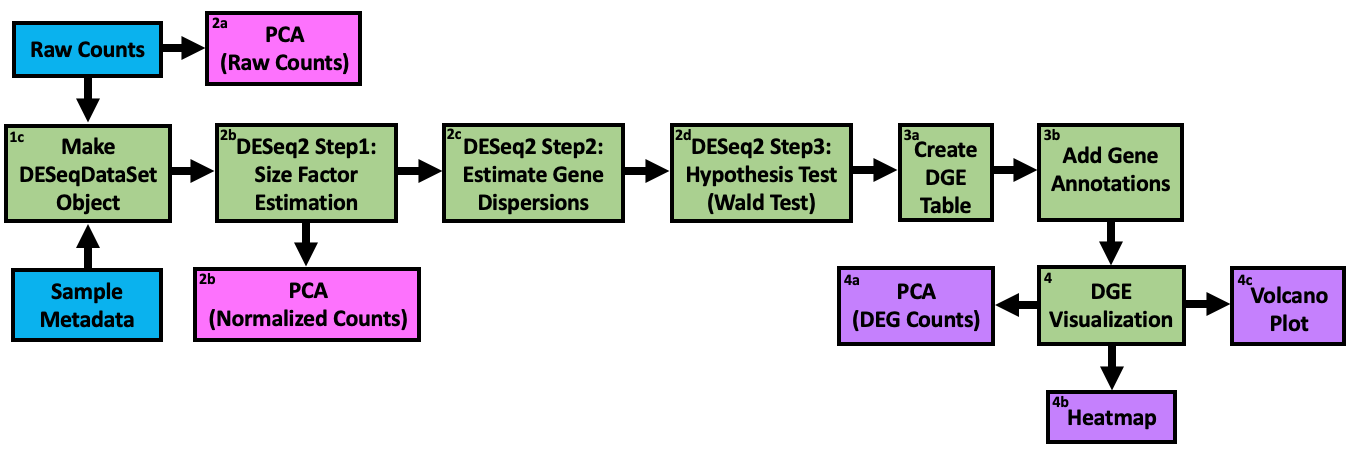

# Table of Contents 


* [0. Load R Libraries](#loadlibraries)
* [1. Import and Format Data](#data)
    * [1a. Set up Directory Path Variables](#dirs)
    * [1b. Import the Data](#import)
    * [1c. Make DESeqDataSet Object](#deseqdataset)
* [2. DESeq2 Data Normalization](#deseq)
    * [2a. PCA of Raw, Unnormalized Count Data](#unnormalized)
    * [2b. DESeq2 Step 1: Size Factor Estimation](#sizefactor)
    * [2c. DESeq2 Step 2: Estimate Gene Dispersions](#dispersions)
    * [2d. DESeq2 Step 3: Hypothesis Testing with Wald Test](#wald)
* [3. DGE Analysis](#dge)
    * [3a. Perform Data Calculations and Create DGE Output Table](#calculations)
    * [3b. Add Gene Annotations](#annotations)
* [4. DGE Data Visualization](#vis)
    * [4a. PCA](#pca)
    * [4b. Heatmap](#heatmap)
    * [4c. Volcano Plot](#volcano)




<a class="anchor" id="loadlibraries"></a>
# 0. Load R Libraries

We will be performing our DGE analysis in the R programming language using several R packages, which have all been installed for you. Prior to beginning the analysis, we first have to load the R packages we will be using by importing the library directories where they are stored. 

<a class="anchor" id="libraries"></a>
## Import R Libraries

Import R library that will allow us to import the RSEM raw counts data table: 

In [1]:
library(tximport)

Import R libraries that will allow us to run DGE analysis with DESeq2:

In [2]:
library(DESeq2)
library(dplyr)
library(tidyverse)
library(tidyr)
library(reshape2)
library(grid)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The follow

Import R libraries that will allow us to perform data visualization:

In [3]:
library(ggplot2)
library(ggfortify)
library(ggdendro)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(tidyHeatmap)

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: ggrepel

Registered S3 methods overwritten by 'ggalt':
  method                  from     
  fortify.table           ggfortify
  grid.draw.absoluteGrob  ggplot2  
  grobHeight.absoluteGrob ggplot2  
  grobWidth.absoluteGrob  ggplot2  
  grobX.absoluteGrob      ggplot2  
  grobY.absoluteGrob      ggplot2  

tidyHeatmap version 1.1.5
If you use tidyHeatmap in published research, please cite:
1) Mangiola et al. tidyHeatmap: an R package for modular heatmap production 
  based on tidy princip

Import R libraries that will allow us to add gene annotations to the DGE output table:

In [4]:
library(STRINGdb)
library(PANTHER.db)

Loading required package: AnnotationDbi


Attaching package: 'AnnotationDbi'


The following object is masked from 'package:dplyr':

    select


Loading required package: AnnotationHub

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: 'dbplyr'


The following objects are masked from 'package:dplyr':

    ident, sql



Attaching package: 'AnnotationHub'


The following object is masked from 'package:Biobase':

    cache


Loading required package: RSQLite

PANTHER.db version 1.0.10



<br>

---

<a class="anchor" id="data"></a>
# 1. Import and Format Data

<a class="anchor" id="dirs"></a>
## 1a. Set up Directory Path Variables

Let's start by creating variables to define the location of our input count and metadata and to indicate where the output data we generate will be printed.

In [5]:
metadata_dir="/gpfs/scratch/asbutler/BioCS123B/GLDS-104/Metadata"
counts_dir="/gpfs/scratch/asbutler/BioCS123B/GLDS-104/03-RSEM_Counts" 
norm_output="./GLDS-104/04-DESeq2_NormCounts"
norm_input="/gpfs/scratch/asbutler/BioCS123B/GLDS-104/04-DESeq2_NormCounts"
pca_dir="./GLDS-104/04-DESeq2_NormCounts/PCA"
DGE_output="./GLDS-104/05-DESeq2_DGE"
DGE_plots="./GLDS-104/05-DESeq2_DGE/DGE_plots"

<a class="anchor" id="import"></a>
## 1b. Import the Data

Before we perform any analysis, we need to import two types of data from files in our directory structure. First, we will import a metadata file that we will use to tell DESeq2 which samples belong in each of the groups (FLT or GC) that we will compare by DGE analysis. Second, we will import the unnormalized expression data file (RSEM raw counts table) that we created after running RSEM gene expression quantification at the end of the fastq_to_rsem Jupyter Notebook.

##### Import metadata table that shows which group each sample belongs to (e.g. FLT or GC) and store it as the variable `sampleTable`

In [6]:
sampleTable <- read.csv(file.path(metadata_dir,"GLDS-104_Group_Metadata.csv"), 
                  header=TRUE, row.names=1, stringsAsFactors=TRUE)

Take a look at the metadata table `sampleTable`. The first column contains sample IDs, and the second column indicates the group to which each sample belongs.

In [7]:
sampleTable

,condition
,<fct>
FLT_Rep1,FLT
FLT_Rep2,FLT
FLT_Rep3,FLT
FLT_Rep4,FLT
FLT_Rep5,FLT
FLT_Rep6,FLT
GC_Rep1,GC
GC_Rep2,GC
GC_Rep3,GC


##### Format metadata tables:
This next code block will pull information from the metadata CSV file we just read in, and format it so that R is able to read and interpret the information. 

In [8]:
# Indicate which samples belong to the spaceflight (FLT) group and which to the ground control (GC) group
if (dim(sampleTable) >= 2){
    group<-apply(sampleTable,1,paste,collapse = " & ") # concatenate multiple factors into one condition per sample
} else{
    group<-sampleTable[,1]
}
group_names <- paste0("(",group,")",sep = "") # human readable group names
group <- make.names(group) # group naming compatible with R models
names(group) <- group_names

Warning message in if (dim(sampleTable) >= 2) {:
"the condition has length > 1 and only the first element will be used"


##### Define all the group comparisons to be used for DGE:
DESeq2 takes in a set of "contrasts" which are the groups that will be compared for DGE.


In [9]:
contrasts <- combn(levels(factor(group)),2) # generate matrix of pairwise group combinations for comparison
contrast.names <- combn(levels(factor(names(group))),2)
contrast.names <- c(paste(contrast.names[1,],contrast.names[2,],sep = "v"),paste(contrast.names[2,],contrast.names[1,],sep = "v")) # format combinations for output table files names
contrasts <- cbind(contrasts,contrasts[c(2,1),])
colnames(contrasts) <- contrast.names

View the contrasts table containing the group comparisons that we made above:

In [10]:
contrasts

(FLT)v(GC),(GC)v(FLT)
FLT,GC
GC,FLT


**Use the contrasts table above to answer the following questions:**

1. How many comparisons are shown? What are they?
2. For the comparisons indicated above, if geneA is up-regulated in the FLT samples, will the log fold change of geneA's expression be positive or negative in the FLT v GC comparison? What about in the GC v FLT comparison?

##### Import RSEM raw gene counts data table generated from Step 6b of the fastq_to_counts JN:

First, we will read in the unnormalized, raw gene counts data table that we generated after running RSEM at the end of the fastq_to_counts JN, and store it in the variable `rawCounts`. Then, we need to format the table so that the counts data are compatible with DESeq2. Because DESeq2 can only take a count matrix composed of integers, we will use the function `ceiling()` to coerce the raw gene counts data to only contain integers.

**Recall:** Why does the RSEM raw counts table contain values other than integers in the first place?

In [11]:
rawCounts <- (as.matrix(read.csv(Sys.glob(file.path(counts_dir,"GLDS-104_Unnormalized_Counts.csv")), header = TRUE, row.names = 1, stringsAsFactors = TRUE)))
rawCounts <- ceiling(rawCounts)

<a class="anchor" id="deseqdataset"></a>
## 1c. Make DESeqDataSet Object

We now need to format the raw counts data table so that DESeq2 can use it to perform DGE analysis. The DESeq2 algorithm requires an input called a _DESeqDataSet_ object, which is a special data format that holds gene expression data and sample group assignments. We will use the `DESeqDataSetFromMatrix()` function provided by DESeq2 to convert our raw counts data table to a _DESeqDataSet_ object.

The `DESeqDataSetFromMatrix()` function takes in:

>1) a matrix of counts data, defined here as the variable `rawCounts`<br>2) a metadata table, describing which group(s) each sample belongs to, defined here as our `sampleTable` variable<br>3) the condition in the metadata table for DESeq2 to use to group the samples for comparison. Here we only have one condition column in our `sampleTable`, titled "condition", which we will used to group samples as either FLT or GC for DGE analysis.

The resulting _DESeqDataSet_ object, which we define as the variable `dds` in the command below, holds the counts data and the group assignments for each sample in an associated "design formula". As we continue analysis with DESeq2, our differential expression results will be added to the _DESeqDataSeq_ object in different slots.


In [12]:
dds <- DESeqDataSetFromMatrix(rawCounts, sampleTable, ~condition)

converting counts to integer mode



We can view the summary of our new _DESeqDataSet_ object by running the command below.

In [13]:
summary(dds)

[1] "DESeqDataSet object of length 55487 with 0 metadata columns"

**Based on the `summary(dds)` output, answer the following question:**

1. How many genes are stored in the _DESeqDataSet_ object?

---

**Challenge:** Use the next few code blocks to see what happens if you run DESeqDataSetFromMatrix() without first converting the counts data to integers. 
> Hint: Pull in the raw data again, like we did at the end of step 1b, but use a different variable name like "RCtest". Then, run the DESeqDataSetFromMatrix() command again using that variable in place of `rawCounts`, but store it in a different variable name, such as "ddsTest".

____________________

##### Filter out genes with a count sum of less than 10 across all samples:
This filtering step removes genes which are uninformative because they are extremely lowly expressed in all samples.

In [14]:
keep <- rowSums(counts(dds)) > 10
dds <- dds[keep,]

Let's take a look at how the _DESeqDataSet_ object has changed.

In [15]:
summary(dds)

[1] "DESeqDataSet object of length 21862 with 0 metadata columns"

**Based on the `summary(dds)` outputs before and after filtering, answer the following questions:**

1. How many genes had a count sum of less than 10 across all samples? 
2. How many genes are stored in the _DESeqDataSet_ object now?

<br>

---

**Challenge:** Use the next few code blocks to see what happens to the number of genes stored in the *DESeqDataSet* object if you filter out genes with a count sum less than 20 across all samples? What about less than 50?  
> Hint: Run the same commands as in the previous two code blocks, but make sure you use different variables (**DO NOT use `keep` or `dds` again**).

_____

Finally, let's write out our _DESeqDataSet_ object to a file so that it can be accessed by the job queue script we'll use in the next section:

In [16]:
write.csv(as.data.frame(counts(dds)), file.path(norm_output,"dds.csv"), row.names=TRUE)

<a class="anchor" id="deseq"></a>
# 2. DESeq2 Data Normalization

Our current counts matrix, held in the variable `rawCounts`, contains raw and unnormalized counts data and thus each sample may have a different read depth. Read depth refers to the number of reads that come off the sequencer for each sample, and depending on the number of samples in each run, there is normal variability in the read number allotted for each sample. 

**Recall:**

* What issues do you think the differences in read depth could cause? Keep in mind we are about to perform a differential gene expression analysis where we are directly comparing the expression of each gene between samples. 
* How could this affect interpretation of downstream results? 

To help answer these questions, let's start by taking a look at the global expression of the unnormalized counts data using a visualization technique called _Principal Component Analysis_ (PCA). PCA is a dimensionality reduction method for high-dimension datasets. Gene expression is high-dimensional data where the genes are the dimensions, or "variables" (in our case, we have 21,939 genes aka dimensions - that's a LOT of data). PCA aims to reduce the number of dimensions/variables by condensing them into vectors which preserve the main sources of information, or variance, in the dataset. These vectors are called _principal components_ or PCs. 



<a class="anchor" id="unnormalized"></a>
## 2a. PCA of Raw, Unnormalized Count Data

##### Perform log2 transformations then calculate principal components of our unnormalized data:

In [17]:
exp_raw <- log2(rawCounts+1)
PCA_raw <- prcomp(t(exp_raw), scale = FALSE)

We can take a look at the PCs using `summary()`: 

In [18]:
summary(PCA_raw)

Importance of components:
                           PC1     PC2     PC3      PC4      PC5     PC6
Standard deviation     43.6448 37.6811 32.3854 30.67426 29.37318 28.1334
Proportion of Variance  0.1819  0.1356  0.1002  0.08987  0.08241  0.0756
Cumulative Proportion   0.1819  0.3175  0.4177  0.50760  0.59000  0.6656
                            PC7      PC8      PC9     PC10     PC11      PC12
Standard deviation     27.56761 26.63664 26.29362 26.01769 25.75606 5.738e-14
Proportion of Variance  0.07259  0.06777  0.06603  0.06465  0.06336 0.000e+00
Cumulative Proportion   0.73819  0.80595  0.87199  0.93664  1.00000 1.000e+00

**Based on the `summary(PCA_raw)` output, answer the following questions:**

1. How many PCs were detected?
2. What percent of the variance is explained by PC1? PC2? (Hint: See *Proportion of Variance*)
3. How are the PCs ranked?

<br>

---

##### Plot the principal components of our unnormalized data:

Next, we'll plot the first 2 PCs against each other, since they explain the majority of the variance in the dataset. 

In this first plot, we'll label all samples so we can see where each sample falls on the plot (Note: This can help us detect potential outliers):

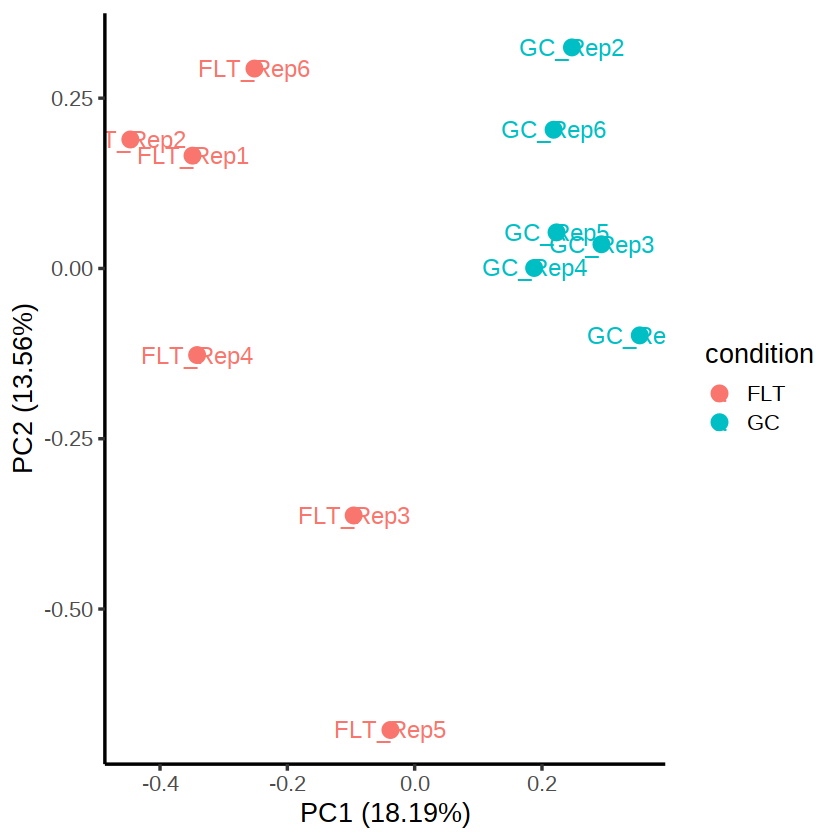

In [19]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=TRUE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

Let's save your PCA plot with all samples labeled to your PCA directory defined in [Step 1a](#dirs) above using the `ggsave()` function. 
> Note: You can adjust the width, height, and dpi of the saved plot until you're satisfied with how the PCA plot looks.

In [20]:
ggsave(file.path(pca_dir,'GLDS-104_PCA_raw_wlabels.png'), width = 8.5, height = 6, dpi = 300)

The PCA plot with all samples labeled is a bit messy, don't you think? Let's create another plot without the sample labels by indicating that the label is FALSE instead of TRUE:

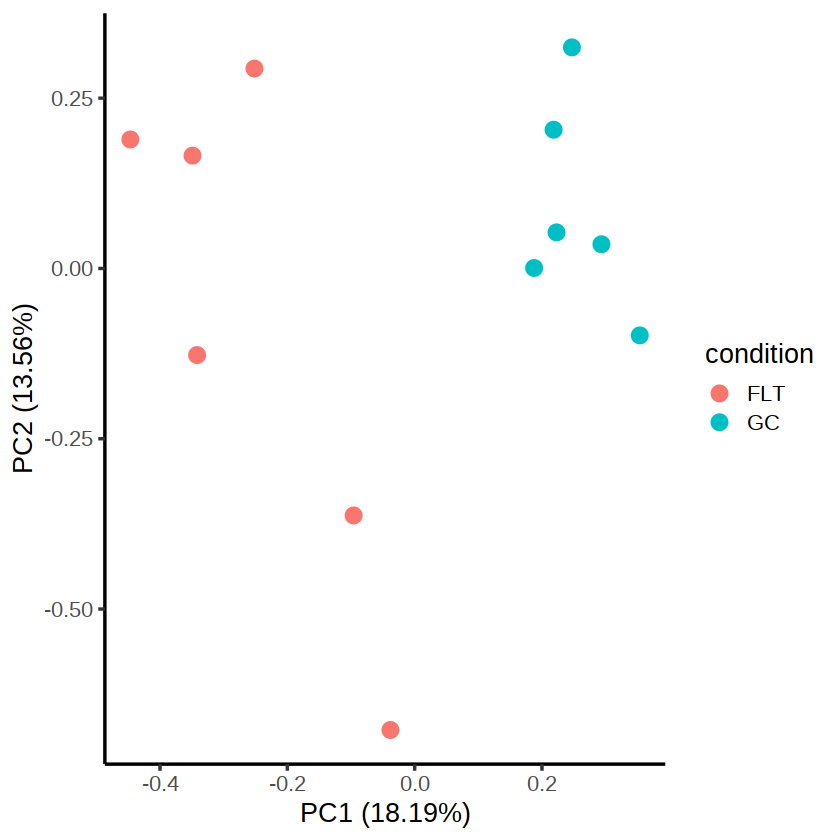

In [21]:
autoplot(PCA_raw, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without sample labels
ggsave(file.path(pca_dir,'GLDS-104_PCA_raw_nolabels.png'), width = 8.5, height = 6, dpi = 300)

Now that you know how to create plots with and without labels indicated, for the remaining PCA plots, we will only show the cleaner plots (without samples labeled). If you want to know which dot represents which sample, you are welcome to change the label back to TRUE in any of the plots we generate below.

Before we move on, let's first save the principal component values of the raw and unnormalized counts: 

In [22]:
write.csv(PCA_raw$x,file.path(pca_dir,"GLDS-104_PCA_raw_table.csv"), row.names=TRUE)

**Take a look at the PCA plots we generated using the raw, unnormalized count data and answer the following questions:**

1. Is there a pattern in how the samples are separating? 

2. Would you expect the data points to separate like this based on their biological conditions? Why or why not?



<a class="anchor" id="sizefactor"></a>
## 2b. DESeq2 Step 1: Size Factor Estimation

We are now ready to begin the DESeq2 analysis, which is composed of 3 steps. 
> Note: To properly allocate compute resources, we will submit a script containing the commands for all 3 steps to a job queue in the next cell. We'll then walk through the each step and provide a description of each command.

In [23]:
system("sbatch /path/to/DGE.slurm", intern=TRUE)

Warning message in system("sbatch /path/to/DGE.slurm", intern = TRUE):
"running command 'sbatch /path/to/DGE.slurm' had status 1"


character(0)
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"

In this first step, called size factor estimation, the algorithm corrects for the sample-wise differences in read depth we observed in step 2c of the fastq_to_counts JN.

**DESeq2 Step 1:** The `estimateSizeFactors()` function provided by DESeq2 performs RNA-seq read depth normalization using the median of ratios method. In this method a *size factor* is calculated for each sample by dividing the median ratio of all gene counts by the geometric mean of each gene across all samples. The raw counts for each sample are then divided by the sample-specific size factor for each gene.

`dds_1 <- estimateSizeFactors(dds)`

<a class="anchor" id="dispersions"></a>
## 2c. DESeq2 Step 2: Estimate Gene Dispersions

Now that our count data are size-normalized, let's move on to the next step in the DESeq2 program: estimating gene dispersions. The _dispersion_ of a gene describes how much the variance of the expression of that gene across all samples deviates from the mean of that gene's expression in the dataset. We are interested in calculating the dispersion of each gene in order to understand whether there is unexpected variability in our dataset which may be due to technical artifacts. 

**DESeq2 Step 2:** Estimate gene dispersions. The `estimateDispersions()` function provided by DESeq2 calculates the gene-wise dispersions and then shrinks them in order to model the size-normalized counts for each gene.

`dds_1 <- estimateDispersions(dds_1)`

##### Visualize the relationship between the gene dispersions and the mean expression of each gene. Each dot represents one gene.

`plotDispEsts(dds_1)`

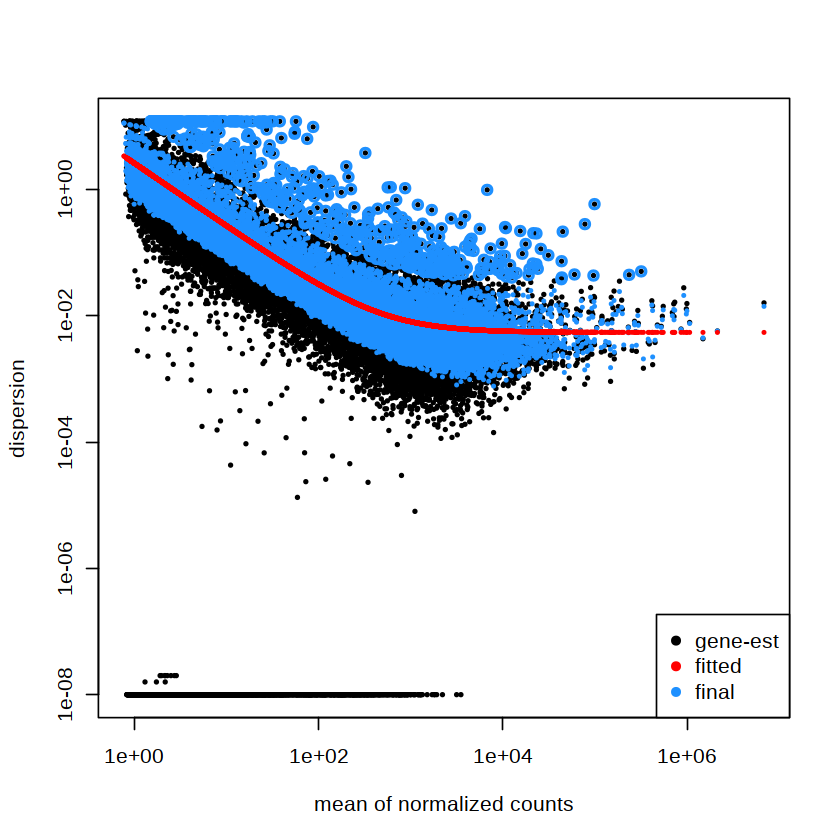

**Use the plot above to answer the following questions:**

1. What is the relationship between gene dispersion and mean expression of a gene? What does this tell you about RNA sequencing data? 
2. How do the gene expression data change before (black dots) and after (blue dots) fitting based on gene dispersion?

<br>

---

<a class="anchor" id="wald"></a>
## 2d. DESeq2 Step 3: Hypothesis Testing with Wald Test

Finally, we are ready to proceed to the third and final step of the DESeq2 process, hypothesis testing. Hypothesis testing will tell us the probability of each gene's expression being significantly different in one of our groups of interest (FLT/GC).

**DESeq2 Step 3:** Fit a negative binomial model to the gene expression data, and perform hypothesis testing using the Wald test with the `nbinomWaldTest()` function provided by DESeq2. The Wald test is like a t-Test in that it calculates a p-value for the probability of each gene's expression being significant in one of the given groups (FLT/GC) as compared to a null distribution/hypothesis.

`dds_1 <- nbinomWaldTest(dds_1)`

**Answer the following questions:**

1. Is the Wald Test the only type of hypothesis testing method we could have used here? (Hint: see the "Likelihood ratio test" section here: http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) 
2. Why did we choose the Wald Test?

<br>

---

##### Export normalized counts as well as the sample table:

`normCounts = as.data.frame(counts(dds_1, normalized=TRUE))`  
`write.csv(normCounts,file=file.path(norm_output,'Normalized_Counts.csv'))`  
`write.csv(sampleTable,file=file.path(norm_output,'SampleTable.csv'))`  

Now that we've normalized our data with [step 2b](#sizefactor) above, let's see how this changes the global gene expression, again using PCA. First, we need to read in the normalized counts table that we wrote out at the end of [step 2d](#wald):

In [24]:
normCounts <- read.csv(file.path(norm_input,'Normalized_Counts.csv'), 
                  header=TRUE, row.names=1, stringsAsFactors=TRUE)

In [25]:
exp_norm <- log2(normCounts+1)
PCA_norm <- prcomp(t(exp_norm), scale = FALSE)

Plot PC1 vs. PC2 without labels:

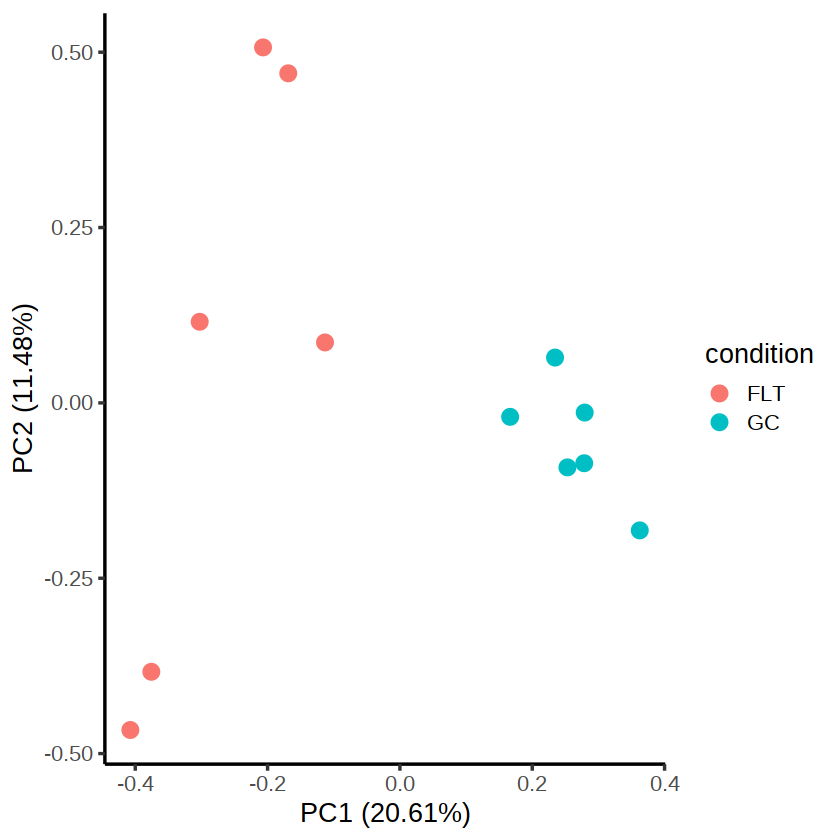

In [26]:
autoplot(PCA_norm, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without sample labels
ggsave(file.path(pca_dir,'GLDS-104_PCA_norm_nolabels.png'), width = 8.5, height = 6, dpi = 300)

**Look at the PCA plots before and after normalization, and answer the following questions:**

1. Is the percent of variance explained by PC2 more or less after normalization? Does that tell you anything about what was contributing to the differences in PC2? 
2. How has the within-group variation changed? Why do you think that is?
3. How has the percent of variance explained by PC1 changed? What does this mean? 

<br>

---

**Challenge:** Use the next few code blocks to 1) list the number of PCs after normalization and 2) recreate the PCA plot but adjust these parameters: label.size, size, alpha (must be between 0 and 1). How does your plot change?
> Hint: 1) Use the `summary()` function we used in step 2a. 2) Fist copy the `autoplot()` command from the previous code block then change the parameters.



<br>

---

<a class="anchor" id="dge"></a>
# 3. DGE Analysis

After completing the DESeq2 analysis, we are now ready to create our DGE output table. To do this, we will start with our normalized counts table generated at the end of [Step 2d](#wald) above and add pair-wise comparison columns containing the FLT vs GC statistal data from the Wald Tests performed in [Step 2d](#wald). We will also perform calculations to generate columns containing all samples as well as group means and standard deviations and complete the table by adding gene annotations. 



<a class="anchor" id="calculations"></a>
## 3a. Perform Data Calculations and Create DGE Output Table

##### Start DGE output table with normalized sample expression values 

In [27]:
DGE_output_table <- normCounts 

Take a look at the first 6 rows of the normalized counts table, which is the start of our DGE table. 

In [28]:
head(DGE_output_table)

,FLT_Rep1,FLT_Rep2,FLT_Rep3,FLT_Rep4,FLT_Rep5,FLT_Rep6,GC_Rep1,GC_Rep2,GC_Rep3,GC_Rep4,GC_Rep5,GC_Rep6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,1012.012473,846.220224,817.921208,850.96214,906.89034,853.512055,996.68593,9.117044e+02,9.566207e+02,8.503539e+02,8.535015e+02,901.80796
ENSMUSG00000000028,105.975990,145.032078,85.220533,135.80222,163.73231,126.807505,119.93316,1.174773e+02,1.197994e+02,1.105363e+02,1.235839e+02,128.68829
ENSMUSG00000000031,79454.042573,77787.535509,83844.270391,88686.66858,60487.63444,68739.422266,118879.40453,1.051442e+05,1.136657e+05,1.115748e+05,1.045086e+05,117678.51505
ENSMUSG00000000037,8.151999,9.588898,8.815917,10.74694,11.87695,6.096515,17.36963,1.004080e+01,8.874032e+00,4.848084e+00,2.896498e+00,15.83856
ENSMUSG00000000049,12.810284,13.184734,22.529566,17.58590,55.99136,12.193029,10.75263,9.036718e+00,1.064884e+01,7.756934e+00,1.448249e+01,11.87892
ENSMUSG00000000056,4452.156139,4528.356947,4575.461032,4652.44743,4237.52783,4526.052495,5252.24537,5.361786e+03,5.051987e+03,5.343558e+03,5.072734e+03,5475.19193


Note: The DGE output table currently has 12 columns (1 for each sample), and the rows are genes (here, the ENSEMBL mouse gene IDs).

##### Iterate through Wald Tests to generate pairwise comparisons of all groups:


First, let's take a look at the contrasts we set up originally:

In [29]:
contrasts

(FLT)v(GC),(GC)v(FLT)
FLT,GC
GC,FLT


We want to iterate through both of those contrasts (FLT vs. GC and GC vs. FLT) and report the log2 fold change, p-value, and adjusted p-value from the Wald Tests we performed in [Step 2d](#wald). 
>Note: We already performed this step at the end of the `DGE.slurm` script we ran in steps 2b-2d above since it requires the DESeq2 DataSet object stored within that script. 

`for (i in 1:dim(contrasts)[2]){`  
`   res_1 <- results(dds_1, contrast=c("condition",contrasts[1,i],contrasts[2,i]))`  
`	res_1 <- as.data.frame(res_1@listData)[,c(2,5,6)]`  
`	colnames(res_1)<-c(paste0("Log2fc_",colnames(contrasts)[i]),paste0("P.value_",colnames(contrasts)[i]),paste0("Adj.p.value_",colnames(contrasts)[i]))`  
`	DGE_output_table <- cbind(DGE_output_table,res_1)`  
`}`  

The updated `DGE_output_table` was written to a .CSV file using the command below: 

`write.csv(DGE_output_table, file.path(norm_output,"DGE_output_table.csv"), row.names=TRUE)`


To retrieve the updated `DGE_output_table` we created at the end of the `DGE.slurm` script, we'll run the following command:

In [30]:
DGE_output_table <- read.csv(file.path(norm_input,"DGE_output_table.csv"), 
                  header=TRUE, row.names=1, stringsAsFactors=TRUE, check.names=FALSE)

##### Perform calculations on the gene counts data:

For each gene, calculate the mean expression and standard deviation across all samples and add these calculations to the DGE output table.

In [31]:
DGE_output_table$All.mean <- rowMeans(normCounts, na.rm = TRUE, dims = 1)
DGE_output_table$All.stdev <- rowSds(as.matrix(normCounts), na.rm = TRUE, dims = 1)

**Challenge:** Use the code block below to look at the DGE output table now. 

> Hint: Use the head() function we used at the beginning of this step (3a).

**Looking at the DGE output table now, answer the following questions:**
1. How many columns have been added? 
2. What is the average experssion of gene, ENSMUSG00000000031 in the FLT group? In the GC group?

Perform mean expression and standard deviation calculations for each gene across samples within each group, and add group means and standard deviations to the DGE_output_table.

In [32]:
tcounts <- as.data.frame(t(normCounts))
tcounts$group <- group
group_means <- as.data.frame(t(aggregate(. ~ group,data = tcounts,mean)))
group_means <- group_means[-c(1),]
colnames(group_means) <- paste0("Group.Mean_",levels(factor(names(group))))
group_stdev <- as.data.frame(t(aggregate(. ~ group,data = tcounts,sd)))
group_stdev <- group_stdev[-c(1),]
colnames(group_stdev) <- paste0("Group.Stdev_",levels(factor(names(group))))

DGE_output_table <- cbind(DGE_output_table,group_means)

DGE_output_table <- cbind(DGE_output_table,group_stdev)

-----

**Use the code block below to look at the DGE output table now.** How many columns have been added?

<a class="anchor" id="annotations"></a>
## 3b. Add Gene Annotations 

Looking at the first column of our DGE table above, you'll notice that the genes are listed as ENSEMBL mouse gene IDs, which doesn't really mean much to anyone unless you have a list of which gene each ENSEMBL ID represents. Since gene names can be long, it may also be useful to know which gene symbol corresponds to each ENSEMBL ID. Furthermore, depending on what downstream analyses you want to run, having a list of IDs from other databases such as RefSeq, Entrez, and/or GOSLIM may be required. Therefore, in this step, we will run a series of commands to add columns to our DGE output table containing other gene identifiers that correspond to the respective ENSEMBL ID.

##### Define the organism that was used for this study
Note: The organism identifer used must match the PANTHER ID for that organism.  

In [33]:
organism <- "MOUSE"

##### Import organism table, which defines the gene annotation databases needed for each organism

In [34]:
organism_table <- read.csv(file.path(metadata_dir,"organisms.csv"))

___

**Challenge:** Use the code block below to view the `organism_table` that you just imported.

**Look at the `organism_table` above and answer the following questions:**

1. What are the first 6 organisms listed in this table? 
2. What is the annotation database used for mice? for humans?

<br>

---

##### Create Gene Annotation table containing various gene identifiers that correspond to the respective ENSEMBL IDs:

Build an annotation database for the organism used in this study (mouse) by pulling in annotations found in the org.Mm.eg.db package:

In [35]:
ann.dbi <- organism_table$annotations[organism_table$name == organism] # Organism specific gene annotation database
ann.dbi=as.character(ann.dbi)
if(!require(ann.dbi, character.only=TRUE)) {
	BiocManager::install(ann.dbi, ask = FALSE)
	library(ann.dbi, character.only=TRUE)
}

Loading required package: org.Mm.eg.db





Use the annotation database (built above) to begin creating an annotation table containing gene annotation columns:
> Note: Additional gene annotations are added by mapping the ENSEMBL mouse gene IDs to their respective IDs in other annotation databases. 

In [36]:
keytype = "ENSEMBL"
annot <- data.frame(rownames(DGE_output_table), stringsAsFactors = FALSE)
colnames(annot)[1]<-keytype
if ("SYMBOL" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
	annot$SYMBOL<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),keys = rownames(DGE_output_table),keytype = keytype, column = "SYMBOL", multiVals = "first")
}
if ("GENENAME" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$GENENAME<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),keys = rownames(DGE_output_table),keytype = keytype, column = "GENENAME", multiVals = "first")
}
if ("ENSEMBL" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$ENSEMBL<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),keys = rownames(DGE_output_table),keytype = keytype, column = "ENSEMBL", multiVals = "first")
}
if ("REFSEQ" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$REFSEQ<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),keys = rownames(DGE_output_table),keytype = keytype, column = "REFSEQ", multiVals = "first")
}
if ("ENTREZID" %in% columns(eval(parse(text = ann.dbi),env=.GlobalEnv))){
        annot$ENTREZID<-mapIds(eval(parse(text = ann.dbi),env=.GlobalEnv),keys = rownames(DGE_output_table),keytype = keytype, column = "ENTREZID", multiVals = "first")
}

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



---

**Challenge:** Use the following code block to view the first 6 rows of our Gene Annotation table, `annot`.
> Hint: Use the `head()` function. 

**Looking at the Gene Annotation table above, answer the following questions:**

1. How many different gene annotations does the table contain?
2. What is the gene name and symbol of ENSEMBL ID: ENSMUSG00000000028? What about ENSEMBL ID: ENSMUSG00000000031?

<br>

---

Next, we'll import and add the STRING annotations from the STRING database to our Gene Annotation table. The STRING database contains protein-protein interactions which are useful for functional enrichment analysis.

In [37]:
string_db <- STRINGdb$new( version="11", species=organism_table$taxon[organism_table$name == organism],score_threshold=0)
string_map <- string_db$map(annot,"SYMBOL",removeUnmappedRows = FALSE, takeFirst = TRUE)[,c(1,6)]
string_map <- string_map[!duplicated(string_map$SYMBOL),]
annot <- dplyr::left_join(annot,string_map, by = "SYMBOL")

The first 6 rows of our STRING annotations table shows gene symbols mapped to STRING IDs:

In [38]:
head(string_map)

,SYMBOL,STRING_id
,<chr>,<chr>
1,GNAI3,10090.ENSMUSP00000000001
2,CDC45,10090.ENSMUSP00000000028
3,H19,10090.ENSMUSP00000028386
4,SCML2,10090.ENSMUSP00000076593
5,APOH,10090.ENSMUSP00000000049
6,NARF,10090.ENSMUSP00000099304


The last set of gene identifiers we'll add to our Gene Annotation table are GOSLIM IDs, which we will import from the PANTHER annotation database.
>Note: Each GOSLIM ID refers to a gene ontology which is a list of genes that corresponds to a biological function.

In [39]:
pthOrganisms(PANTHER.db) <- organism
panther <- mapIds(PANTHER.db,keys = annot$ENTREZID,keytype = "ENTREZ",column = "GOSLIM_ID", multiVals = "list")
panther <- na.omit(panther)
annot$GOSLIM_IDS <- panther

Let's take a look at the first row of our final Gene Annotations table, which now contains the original gene annotations (ENSEMBL, SYMBOL, GENENAME, REFSEQ, ENTREZID), the STRING IDs, and the GOSLIM IDs from the Panther database:

In [40]:
head(annot, n=1)

,ENSEMBL,SYMBOL,GENENAME,REFSEQ,ENTREZID,STRING_id,GOSLIM_IDS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<named list>
1,ENSMUSG00000000001,Gnai3,"guanine nucleotide binding protein (G protein), alpha inhibiting 3",NM_010306,14679,NA,"GO:0001664, GO:0003824, GO:0003924, GO:0004016, GO:0004888, GO:0004930, GO:0005102, GO:0005488, GO:0005515, GO:0005622, GO:0005623, GO:0005886, GO:0007154, GO:0007165, GO:0007186, GO:0007187, GO:0007188, GO:0009898, GO:0009966, GO:0009975, GO:0009987, GO:0010646, GO:0016020, GO:0016462, GO:0016787, GO:0016817, GO:0016818, GO:0016829, GO:0016849, GO:0017111, GO:0019897, GO:0019898, GO:0019932, GO:0019933, GO:0019935, GO:0023051, GO:0023052, GO:0031234, GO:0031279, GO:0032991, GO:0035556, GO:0038023, GO:0043949, GO:0044424, GO:0044425, GO:0044459, GO:0044464, GO:0044877, GO:0045761, GO:0048583, GO:0050789, GO:0050790, GO:0050794, GO:0050896, GO:0051339, GO:0051716, GO:0060089, GO:0065007, GO:0065009, GO:0071944, GO:0097478, GO:0098552, GO:0098562, GO:0098796, GO:0098797, GO:1902494, GO:1902531"


**Looking at the first row of our Gene Annotations table above, answer the following questions:**

1. What is the name of the gene shown?
2. How many biological functions involve *Gnai3*? (Hint: Look at the GOSLIM IDs) 

##### Combine Gene Annotation table with the DGE output table generated in [Step 3a](#calculations) to create the final DGE output table:

In [41]:
DGE_output_table <- cbind(annot,DGE_output_table)
rownames(DGE_output_table) <- NULL

DGE_output_table$GOSLIM_IDS <- vapply(DGE_output_table$GOSLIM_IDS, paste, collapse = ", ", character(1L))

Take a look at the first row of the final DGE output table.

In [42]:
head(DGE_output_table, n=1) # Scroll to the right to see all the columns we've added

,ENSEMBL,SYMBOL,GENENAME,REFSEQ,ENTREZID,STRING_id,GOSLIM_IDS,FLT_Rep1,FLT_Rep2,FLT_Rep3,⋯,Adj.p.value_(FLT)v(GC),Log2fc_(GC)v(FLT),P.value_(GC)v(FLT),Adj.p.value_(GC)v(FLT),All.mean,All.stdev,Group.Mean_(FLT),Group.Mean_(GC),Group.Stdev_(FLT),Group.Stdev_(GC)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000000001,Gnai3,"guanine nucleotide binding protein (G protein), alpha inhibiting 3",NM_010306,14679,NA,"GO:0001664, GO:0003824, GO:0003924, GO:0004016, GO:0004888, GO:0004930, GO:0005102, GO:0005488, GO:0005515, GO:0005622, GO:0005623, GO:0005886, GO:0007154, GO:0007165, GO:0007186, GO:0007187, GO:0007188, GO:0009898, GO:0009966, GO:0009975, GO:0009987, GO:0010646, GO:0016020, GO:0016462, GO:0016787, GO:0016817, GO:0016818, GO:0016829, GO:0016849, GO:0017111, GO:0019897, GO:0019898, GO:0019932, GO:0019933, GO:0019935, GO:0023051, GO:0023052, GO:0031234, GO:0031279, GO:0032991, GO:0035556, GO:0038023, GO:0043949, GO:0044424, GO:0044425, GO:0044459, GO:0044464, GO:0044877, GO:0045761, GO:0048583, GO:0050789, GO:0050790, GO:0050794, GO:0050896, GO:0051339, GO:0051716, GO:0060089, GO:0065007, GO:0065009, GO:0071944, GO:0097478, GO:0098552, GO:0098562, GO:0098796, GO:0098797, GO:1902494, GO:1902531",1012.012,846.2202,817.9212,⋯,0.6276981,0.05022194,0.4393949,0.6276981,896.5161,63.22027,881.2531,911.7791,70.25756,57.42596


Each row of the DGE output table contains data for one gene. 

The DGE output table contains the following columns:
* ENSEMBL, SYMBOL, GENENAME, REFSEQ, ENTREZID - these are all various gene ID systems
* STRING_id - the protein ID for the STRING database, used to identify protein-protein interactions
* GOSLIM_IDs - all gene ontology IDs for functional gene sets to which this gene belongs
* FLT_Rep1, FLT_Rep2, FLT_Rep3... All 12 of our samples are listed here with normalized counts for this gene for each sample.
* Log2fc(GC)v(FLT), P.value_(GC)v(FLT), Adj.p.value_(GC)v(FLT) - log2 fold change, pvalue, and adjusted pvalue for the Wald test comparison of the GC group samples to the FLT group samples.
* All.mean, All.stdev, LRT.p.value - mean, standard deviation, and pvalue across all samples. 
>Note that the GeneLab standard pipeline generates the LRT p values, but in this exercise we are just generating the Wald values, so there are no LRT columns in this output table.
* Group.Mean_(FLT), Group.Mean_(GC), Group.Stdev_(FLT), Group.Stdev_(GC) - mean and standard deviation within the FLT and GC groups.


The last step of the DGE analysis is to save the table containg the contrasts we used for DGE analysis and our final DGE table.

In [43]:
write.csv(contrasts,file.path(DGE_output, "contrasts.csv"))
write.csv(DGE_output_table,file.path(DGE_output, "differential_expression.csv"), row.names=FALSE)

<br>

---

<a class="anchor" id="vis"></a>
# 4. DGE Data Visualization
Let's create some common gene expression visualization plots.

First, perform log transformations of the normalized expression data for plotting.

In [45]:
exp_norm <- log2(normCounts+1)

Filter the DEGs to just those with an adjusted p-value < 0.05 and |Log2 fold change| > 1. These are accepted practices for identifying significantly differentially expressed genes.

In [46]:
dge_p <- DGE_output_table[DGE_output_table$`Adj.p.value_(GC)v(FLT)`<0.05,] # filter by adj p-value
dge_p_flc_up <- dge_p[dge_p$`Log2fc_(GC)v(FLT)`>1,] # filter by lfc > 1
dge_p_flc_down <- dge_p[dge_p$`Log2fc_(GC)v(FLT)`< -1,] # filter by lfc < -1
dge_full <- rbind(dge_p_flc_up, dge_p_flc_down) # merge together

dge_p_flc <- dge_full[rowSums(is.na(dge_full)) != ncol(dge_full), ] # remove rows with NA

Let's look at the dimensions of our filtered DGE table:

In [47]:
dim(dge_p_flc)

[1] 768  31

**Use the filtered DGE table to answer the following questions:**

1. Why was the adjusted p-value used to determine signifigance rather than p-value? 
2. How many significant DEGs are there? (Hint: Look at the dimensions of the matrix (reported in rows by columns, or genes by samples)
3. Based on the adjusted p-value cutoff used, how confident are we (in %) that those genes are DE?

Create a subset expression matrix containing only significant DEGs:

In [48]:
exp_dge <- exp_norm[dge_p_flc$ENSEMBL,]
dim(exp_dge)

[1] 768  12

<br>

---

<a class="anchor" id="pca"></a>
## 4a. PCA
We can perform another Principal Component Analysis using only the significant DEGs.

##### Repeat PCA using only DEGs: 

In [49]:
PCA_dge <- prcomp(t(exp_dge), scale = FALSE)

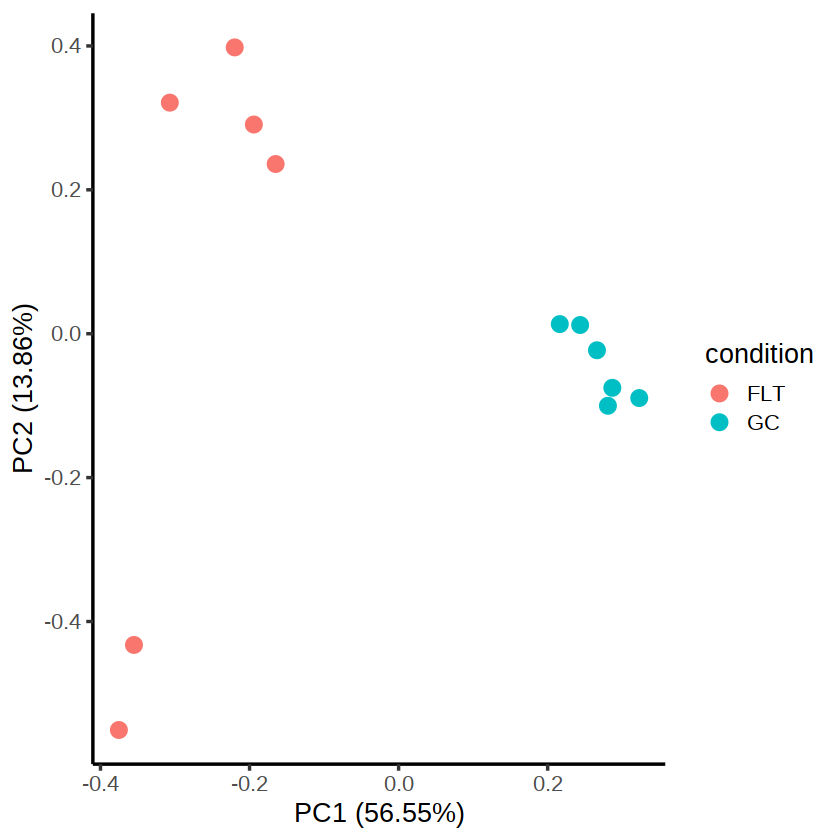

In [50]:
## Create your PCA plot without samples labeled
autoplot(PCA_dge, data=sampleTable, colour='condition', 
         label=FALSE, label.size=5, size=4, alpha=1) + theme_classic(base_size = 16)

## Save your PCA plot without samples labeled
ggsave(file.path(DGE_plots,'GLDS-104_PCA_DGE_nolabels.png'), width = 8.5, height = 6, dpi = 300)

**Compare this PCA plot to the plot we made in [Step 2b](#sizefactor) using all normalized counts, and answer the following questions:**

1. How has the percent of variance explained by PC1 changed? What is responsible for this change? 
2. Is there anything interesting to note about PC2?

<br>

---

##### Try creating more plots with autoplot, changing the parameters and see how the PCA plot changes.


<a class="anchor" id="heatmap"></a>
## 4b. Heatmap

Heatmaps are commonly used to visualize gene expression data to see overall trends between samples in large lists of genes. Here, we will use a heatmap to examine the expression of our DEGs in the FLT and GC samples.

Before creating the heatmap, we'll first scale the counts data between 0 and 1. This makes it easier to visualize relative expression levels.

In [51]:
exp_dge_scale <- apply(exp_dge, MARGIN = 2, FUN = function(X) (X - min(X))/diff(range(X)))

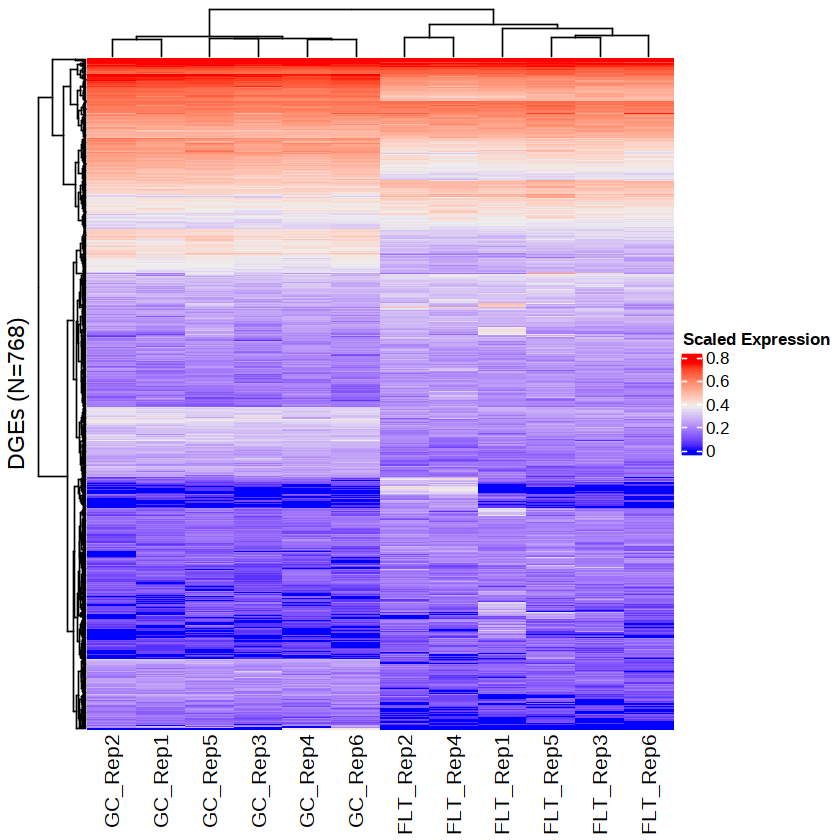

In [52]:
Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DGEs (N=768)", 
   heatmap_legend_param = list(title="Scaled Expression"))

Next, we'll generate the heatmap again, but this time, let's save it to a variable:

In [53]:
heatmap = Heatmap(exp_dge_scale, show_row_names=FALSE, row_title="DGEs (N=768)", 
   heatmap_legend_param = list(title="Scaled Expression"))

Now we can use the variable `heatmap` to save the image as a pdf with the function, `save_pdf()`:

In [54]:
save_pdf(heatmap, file.path(DGE_plots,'GLDS-104_heatmap_DGE.pdf'),
        width = 5, height = 5, units = c("in", "cm", "mm"))

**Use the heatmap to answer the following questions:**

1. What overall trends do you notice in the expression of the DEGs in samples within the same group? What about samples in different groups?

<br>

---

**Challenge:** Recall that before generating the heatmap, we first scaled the expression data. Use the following code block to see what the heatmap looks like if you don't scale the data. 
> Hint: Use the `Heatmap()` function again, but replace `exp_dge_scale` with `exp_dge`. 

What if we don't log normalize the data, either? **Spoiler alert:** this crashes the kernel in the Jupyter Hub! Why do you think this is? 

We've generated this plot locally and provided it here. Is this a useful plot? 

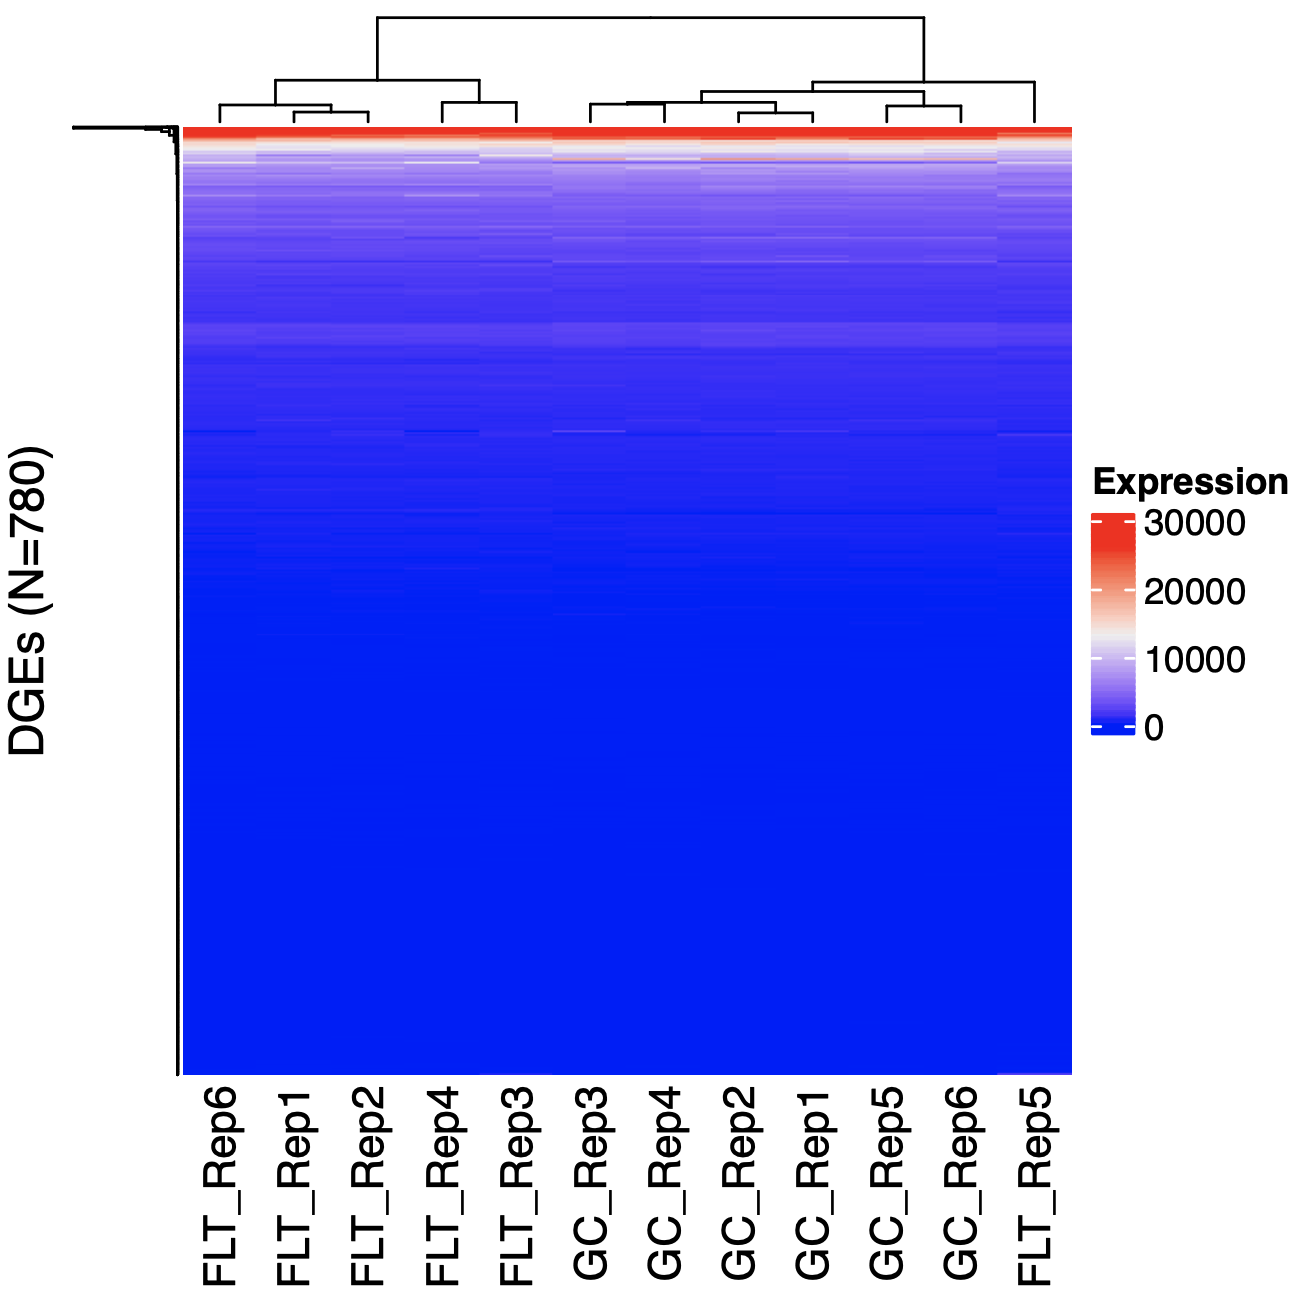

<a class="anchor" id="volcano"></a>
## 4c. Volcano Plot

Finally, let's make a volcano plot to identify a few interesting genes. A volcano plot is a scatterplot which shows the relationship of the adjusted p-value to the log2 fold change. Genes with large fold changes that are also statistically significant by adjusted p-value are labeled.

First, we'll use the default settings from the `EnhancedVolcano()` function: log2 Fold Change cutoff > |2|, and the adjusted p-value cutoff is < 10e-6. 
>Note: You can read more about the `EnhancedVolcano()` function and see some examples by clicking [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html)

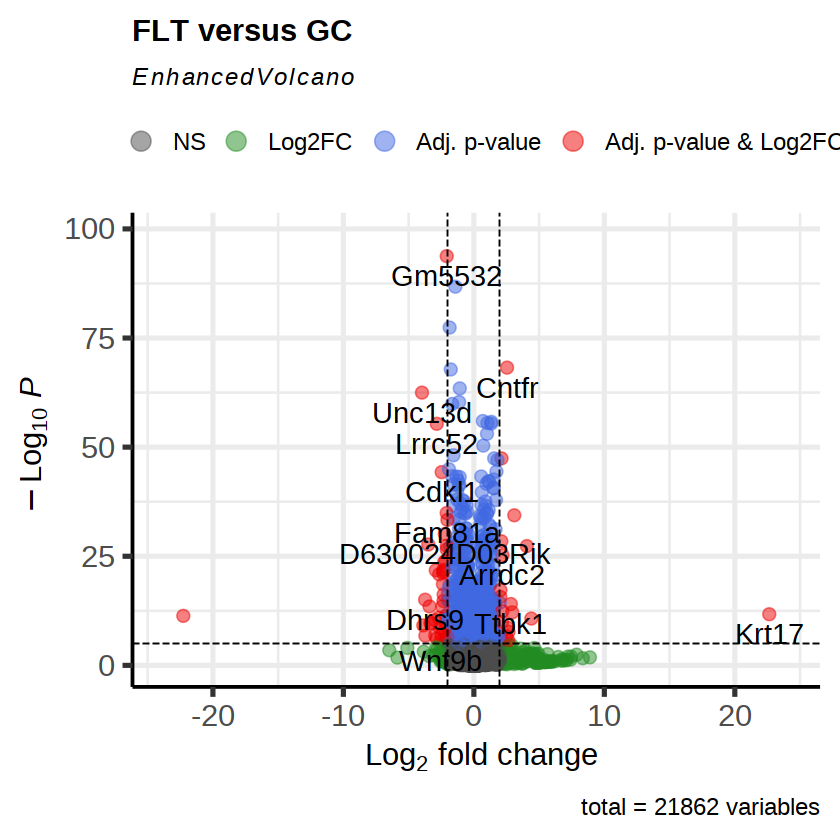

In [55]:
# Volcano plot showing genes differentially expressed in FLT vs GC
EnhancedVolcano(DGE_output_table,
    lab = DGE_output_table$SYMBOL,
    x = 'Log2fc_(FLT)v(GC)',
    y = 'Adj.p.value_(FLT)v(GC)',
    title = 'FLT versus GC',
    legendLabels=c('NS','Log2FC','Adj. p-value',
      'Adj. p-value & Log2FC'),
    pCutoff = 10e-6,
    FCcutoff = 2,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha=0.5)

## Save your volcano plot
ggsave(file.path(DGE_plots,'GLDS-104_volcano_DGE.png'), width = 6, height = 8.5, dpi = 300)

**Use the volcano plot (and our collective conscious - aka the internet) to answer the following questions:**

1. Which gene has the smallest adjusted p-value that still passes our Log2FC cutoff? 
2. Is *Gm5532* more highly expressed in FLT or GC samples? How do you know?
3. Which gene is most highly expressed in the FLT group? Does this gene also pass the adjusted p-value cutoff?
4. Since *Gm5532* is the most highly differentially expressed gene, see if you can find its biological function (feel free to use your friend Google to help you out). Are you able to find an annotated function? 
5. What is the function of the gene *Krt17* ? Is it more highly expressed in the FLT or GC condition? Based on its function, why do you think this is?

<br>

---

**Challenge:** Use the code blocks below to create another volcano plot (or two) with different adjusted p-value and log2FC cutoffs and see how the plot changes. 
> Hint: Start with the `EnhancedVolcano()` command above then change the values corresponding to the adjusted p-value and log2FC cutoffs. If you're unsure what those are, take a look at the `EnhancedVolcano()` documentation [here](https://bioconductor.org/packages/release/bioc/vignettes/EnhancedVolcano/inst/doc/EnhancedVolcano.html).